<a href="https://colab.research.google.com/github/remanx2558/MIDBReviews/blob/master/FastText_Muti_Channel_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np


movie_reviews = pd.read_csv(r"/content/drive/My Drive/malia/train.csv")

movie_reviews.isnull().values.any()
movie_reviews.sentiment= movie_reviews.sentiment.fillna(0.0).astype(int)#this will conver float into int and also manage missing values

movie_reviews.shape

(25005, 2)

In [0]:


def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence



In [0]:


import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)



In [0]:
reviews = []
sentences = list(movie_reviews['text'])
for sen in sentences:
    reviews.append(preprocess_text(sen))
movie_reviews['text'] = reviews

In [10]:
import os
import sys
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from gensim.models import KeyedVectors

Using TensorFlow backend.


In [13]:
tokenizer = Tokenizer(num_words=200)
tokenizer.fit_on_texts(movie_reviews['text'])
sequences = tokenizer.texts_to_sequences(movie_reviews['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

MAX_SEQUENCE_LENGTH = 1000

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels = to_categorical(np.asarray(movie_reviews['sentiment']))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 73268 unique tokens.
Shape of data tensor: (25005, 1000)
Shape of label tensor: (25005, 2)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(data, labels, test_size=0.5, random_state=42)

In [15]:
!wget https://drive.google.com/open?id=1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq

--2020-06-14 09:10:44--  https://drive.google.com/open?id=1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq
Resolving drive.google.com (drive.google.com)... 74.125.140.101, 74.125.140.138, 74.125.140.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.140.101|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://drive.google.com/file/d/1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq/view?usp=drive_open [following]
--2020-06-14 09:10:44--  https://drive.google.com/file/d/1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq/view?usp=drive_open
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘open?id=1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq’

open?id=1xzt06g_xeP     [ <=>                ]  68.24K  --.-KB/s    in 0.02s   

2020-06-14 09:10:44 (2.74 MB/s) - ‘open?id=1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq’ saved [69876]



In [18]:
model_ft = KeyedVectors.load_word2vec_format('/content/drive/My Drive/malia/wiki-news-300d-1M.vec', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
import keras

In [22]:
vocabSize = len(word_index) + 1
# Querying SQLlite database to extract needed words embeddings
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(movie_reviews['text'])
vocabSize = len(tokenizer.word_index) + 1
vocabSize

73269

In [23]:
EMBEDDING_DIM = 300
MAX_NUM_WORDS=500
print('Preparing embedding matrix.fast text')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
print(num_words)
embedding_matrix = np.zeros((vocabSize, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    if word in model_ft.vocab:
      embedding_vector = model_ft[word]
      embedding_vector = np.array(embedding_vector)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

Preparing embedding matrix.fast text
500
(73269, 300)


In [24]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import Flatten
from keras.initializers import Constant

print('Training model.')

# define the model
model = Sequential()
model.add(Embedding(vocabSize,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# summarize the model
print(model.summary())

model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          validation_data=(x_val, y_val))

Training model.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 300)         21980700  
_________________________________________________________________
flatten_1 (Flatten)          (None, 300000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               153600512 
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 175,745,694
Trainable params: 153,764,994
Non-trainable params: 21,980,700
_______________

In [25]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))

Accuracy: 0.915454
Loss: 0.269852


In [0]:
from keras.preprocessing.text import text_to_word_sequence
import keras


In [0]:
reviews = [ str(r) for r in movie_reviews['text'].values]
labels = movie_reviews['sentiment'].values

for idx, review in enumerate(movie_reviews):
    words = text_to_word_sequence(review)
    if(len(words) > 40): 
        words = words[:40]
        movie_reviews[idx] = ' '.join(words)

oneHotReviews = tokenizer.texts_to_sequences(reviews)
encodedReviews = keras.preprocessing.sequence.pad_sequences(oneHotReviews, maxlen=1000, padding='post')

X_train, X_test, y_train, y_test = train_test_split(encodedReviews, labels, test_size=0.33, random_state=42)

In [0]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

In [33]:
NN = keras.models.Sequential()
NN.add(keras.layers.Embedding(vocabSize, 300, weights=[embedding_matrix], input_length=1000, trainable=True))
NN.add(Conv1D(filters=32, kernel_size=4, padding='valid', activation='relu'))
NN.add(Dropout(0.5))
NN.add(MaxPooling1D())
NN.add(Conv1D(filters=32, kernel_size=6, padding='valid', activation='relu'))
NN.add(Dropout(0.5))
NN.add(MaxPooling1D())
NN.add(keras.layers.Flatten())
NN.add(keras.layers.Dense(10, activation='relu'))
NN.add(Dropout(0.5))
NN.add(keras.layers.Dense(1, activation='sigmoid'))
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
NN.fit(X_train, y_train, epochs=5, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
16753/16753 [==============================] - 25s 2ms/step - loss: 0.6229 - acc: 0.6109
Epoch 2/5
16753/16753 [==============================] - 21s 1ms/step - loss: 0.3332 - acc: 0.8693
Epoch 3/5
16753/16753 [==============================] - 21s 1ms/step - loss: 0.1963 - acc: 0.9308
Epoch 4/5
16753/16753 [==============================] - 21s 1ms/step - loss: 0.1260 - acc: 0.9585
Epoch 5/5
16753/16753 [==============================] - 21s 1ms/step - loss: 0.0966 - acc: 0.9685


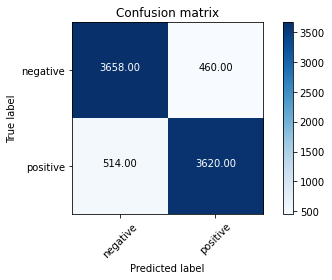

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import tensorflow.contrib.keras as keras
import matplotlib.pyplot as plt
import os
import sys
import pickle
import itertools
import gensim
from sklearn.model_selection import train_test_split
from numpy import zeros
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec
predictions = NN.predict_classes(X_test)

cm = confusion_matrix(y_test, predictions, labels=[0,1])
title = 'Confusion matrix'
cmap = plt.cm.Blues
classes=["negative","positive"]
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [39]:
report = classification_report(y_test, predictions, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4118
           1       0.89      0.88      0.88      4134

    accuracy                           0.88      8252
   macro avg       0.88      0.88      0.88      8252
weighted avg       0.88      0.88      0.88      8252

